In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pyNBS as nbs
from scipy import stats
import os
import qvalue

# Create Personalized PagePank matrix

In [3]:
file_name = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
network_output_dir = '../data/FI_prop'
network, gene2index=nbs.load_network(file_name,network_output_dir)

* Loading PPI...
	- Edges: 228919
	- Nodes: 12175
* Removing self-loops, multi-edges, and restricting to largest connected component...
	- Largest CC Edges: 228827
	- Largest CC Nodes: 12033
* Saving updated node list to file...


It takes a long time to compute the inverse matrix. But it only has to be done once.

In [4]:
rst_prob = 0.5

PPR = nbs.create_ppr_matrix(network,rst_prob,network_output_dir)

* Creating PPR  matrix...


# Load PPR matrix

In [5]:
network_output_dir = '../data/FI_prop'

PPR = np.load('{}/ppr_0.5.npy'.format(network_output_dir))

In [6]:
def rnaseq2whiteList(fn):
    df_exp = pd.read_table(fn,index_col=0,skiprows=[1],low_memory=False)
    df_exp.columns = df_exp.columns.str[:12]
    df_exp.index = pd.DataFrame(df_exp.index.str.split('|').tolist())[0]
    df_exp.drop('?',inplace=True)
    df_exp = df_exp.groupby(level=0).sum().clip(lower=1./8)
    df_exp = df_exp.loc[df_exp.median(axis=1)>1./8,:]
    white_list = set(df_exp.index)
    return white_list

In [7]:
fn = '/cellar/data/users/wzhang1984/Firehose/Firehose__2015_08_21/stddata/HNSC/rnaseqv2/illuminahiseq_rnaseqv2/unc_edu/\
Level_3/RSEM_genes_normalized/data/data.txt'
white_list_1 = rnaseq2whiteList(fn)

fn = '/cellar/data/users/wzhang1984/Firehose/Firehose__2015_08_21/stddata/CESC/rnaseqv2/illuminahiseq_rnaseqv2/unc_edu/\
Level_3/RSEM_genes_normalized/data/data.txt'
white_list_2 = rnaseq2whiteList(fn)

white_list = white_list_1 | white_list_2

In [8]:
len(white_list)

17864

In [9]:
with open('{}/index_genes'.format(network_output_dir)) as file_handle:
    genes_in_FI = set([a[1] for a in [line.split() for line in file_handle.read().splitlines()]])
FI_white_list=genes_in_FI&white_list

# Propagate MIST

In [10]:
print 'Reading UniProt to name mapping'
UniProt2name={}
for line in open('../data/uniprot2name.txt'):
    a=line.split('\n')[0].split('\t')
    if a[1]:
        if a[1] not in UniProt2name:
            UniProt2name[a[1]]=set()
        UniProt2name[a[1]]|=set([a[0],a[2],a[3]])

Reading UniProt to name mapping


In [11]:
# TODO: clean up this part
gene2bait={}
gene2bait_75={}
gene2MIST={}
gene2MIST_bait={}
for fn in ['../data/Het1A-APMS.txt','../data/141205_HPV_C33A_ALLSCORES.txt',
           '../data/141202_HEK293_noME4_preprocessed_NoC_MAT_ALLSCORES.txt']:
    if fn=='../data/Het1A-APMS.txt':
        cell='Het1A'
    elif fn=='../data/141205_HPV_C33A_ALLSCORES.txt':
        cell='C33A'
    elif fn=='../data/141202_HEK293_noME4_preprocessed_NoC_MAT_ALLSCORES.txt':
        cell='HEK293'
    print cell
    header=True
    c2i={}
    for line in open(fn).read().rstrip().split('\n'):
        a=line.split('\t')
        if header:
            for i in range(len(a)):
                c2i[a[i]]=i
            header=False
            continue
        Bait=a[c2i['Bait']]
        try:
            if fn=='../data/Het1A-APMS.txt':
                Bait=Bait.split('_')[0][5:]
            else:
                Bait=Bait.split('_')[1]
        except:
            continue
        Prey=a[c2i['Prey']]
        Entry_name=a[c2i['Entry.name']]
        MIST=float(a[c2i['MIST']])
        names=set()
        name=''
        if 'name' in c2i:
            name=a[c2i['name']]
            names.add(name)
        names.add(Entry_name.split('_')[0])
        if Prey in UniProt2name:
            for name_i in UniProt2name[Prey]:
                names.add(name_i)
        for name_i in a[c2i['Gene.names']].split(' '):
            names.add(name_i)
        for name_i in names:
            if name_i in white_list:
                if cell not in gene2MIST:
                    gene2MIST[cell]={}
                    gene2MIST_bait[cell]={}
                if name_i not in gene2MIST[cell]:
                    gene2MIST[cell][name_i]=0
                if MIST>=0.75:
                    if name_i not in gene2bait_75:
                        gene2bait_75[name_i]={}
                    if Bait not in gene2bait_75[name_i]:
                        gene2bait_75[name_i][Bait]=set()
                    gene2bait_75[name_i][Bait].add(cell)
                if MIST>=gene2MIST[cell][name_i]:
                    gene2MIST_bait[cell][name_i]=Bait
                    if name_i not in gene2bait:
                        gene2bait[name_i]={}
                    if Bait not in gene2bait[name_i]:
                        gene2bait[name_i][Bait]=set()
                    gene2bait[name_i][Bait].add(cell)                
                else:
                    if name_i in gene2bait and Bait in gene2bait[name_i] and cell in gene2bait[name_i][Bait] and gene2MIST_bait[cell][name_i]!=Bait:
                        gene2bait[name_i][Bait]=gene2bait[name_i][Bait]-set([cell])
                gene2MIST[cell][name_i]=max(gene2MIST[cell][name_i],MIST)

Het1A
C33A
HEK293


In [12]:
def df_permutation(df, n_permute):
    for i in range(n_permute):
        df['permutation{}'.format(i+1)] = np.random.permutation(df.iloc[:,0])
    return df.T

In [13]:
gene2MIST_C33A = pd.DataFrame(gene2MIST['C33A'].items(),columns=['gene','score']).set_index('gene')

tmp = pd.DataFrame(index=white_list,columns=['score'])
tmp.update(gene2MIST_C33A)
gene2MIST_C33A = tmp.fillna(0).sort_index()
del tmp

n_permute = 20000
gene2MIST_C33A = df_permutation(gene2MIST_C33A, n_permute)

In [14]:
output_dir = '../data/MIST_prop'

mutation_profile_MIST, pat2index = nbs.load_mutation_from_df(gene2MIST_C33A,output_dir,gene2index)

	- Genes in adjacency matrix: 10225
* Saving patient list to file...


In [15]:
pat_diff_MIST = nbs.run_diffusion_PPR(PPR,mutation_profile_MIST)

# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,pat_diff_MIST)

print 'Finish propagating the data...'

Finish propagating the data...


In [16]:
MIST_prop = np.load('{}/prop_pat_mut.npy'.format(output_dir))
with open('{}/index_genes'.format(network_output_dir)) as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('{}/index_patients'.format(output_dir)) as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
MIST_prop=pd.DataFrame(data=MIST_prop,index=pats,columns=genes)

In [17]:
MIST_prop_p = (MIST_prop.iloc[0,:]-MIST_prop.iloc[1:,:]<=0).sum()/float(n_permute)

# Propagate differential mutation rate (HNSC + CESC)

In [18]:
M2 = pd.read_table('../data/glmBinomial_anovaChisq/glmBinomialAnovaChisq_HNSC_CESC_2cov.txt', index_col=0, header=None, 
                   names=['gene','mut_type','pval','rate_p','rate_n','mut_rate','score']).sort_values('pval')

In [19]:
# M2['score'] = np.abs(M2['score'])
M2['score'] = M2['score'].clip(lower=0)
gene2difMut = M2['score']

tmp = pd.DataFrame(index=white_list,columns=['score'])
tmp.update(gene2difMut)
gene2difMut = tmp.fillna(0).sort_index()
del tmp

n_permute = 20000
gene2difMut = df_permutation(gene2difMut, n_permute)

In [20]:
output_dir = '../data/difMut_prop'

mutation_profile_difMut, pat2index = nbs.load_mutation_from_df(gene2difMut,output_dir,gene2index)

	- Genes in adjacency matrix: 10225
* Saving patient list to file...


In [21]:
pat_diff_difMut = nbs.run_diffusion_PPR(PPR,mutation_profile_difMut)

# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,pat_diff_difMut)

print 'Finish propagating the data...'

Finish propagating the data...


In [22]:
output_dir = '../data/difMut_prop'
difMut_prop = np.load('{}/prop_pat_mut.npy'.format(output_dir))
with open('{}/index_genes'.format(network_output_dir)) as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('{}/index_patients'.format(output_dir)) as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
difMut_prop=pd.DataFrame(data=difMut_prop,index=pats,columns=genes)

In [23]:
difMut_prop_p = (difMut_prop.iloc[0,:]-difMut_prop.iloc[1:,:]<=0).sum()/float(n_permute)

# Combine P-values

In [24]:
df_combined_prop_p = pd.concat([difMut_prop.iloc[0,:],MIST_prop.iloc[0,:],difMut_prop_p,MIST_prop_p],axis=1)
df_combined_prop_p.columns = ['Deviance_prop','MIST_prop','difMut_prop_p','MIST_prop_p']

In [25]:
# combined_prop: Product of the 2 propagation scores
# combined_prop_p: Empirical p-value of this product comparing with null distribution by permutations
# combined_prop_fdr: Story multiple test correction (q-value)
combined_prop = difMut_prop*MIST_prop
combined_prop_p = (combined_prop.iloc[0,:]-combined_prop.iloc[1:,:]<=0).sum()/float(n_permute)
combined_prop_fdr = combined_prop_p.copy()
combined_prop_fdr[:] = qvalue.estimate(combined_prop_p)

In [26]:
df_combined_prop_p = pd.concat([df_combined_prop_p,combined_prop_p,combined_prop_fdr],axis=1).dropna()
df_combined_prop_p.columns = ['Deviance_prop','MIST_prop','difMut_prop_p','MIST_prop_p','combined_prop_p',
                             'combined_prop_fdr']
df_combined_prop_p = df_combined_prop_p.sort_values(by=['combined_prop_p'])

In [27]:
df_combined_prop_p.iloc[:60,:]

,Deviance_prop,MIST_prop,difMut_prop_p,MIST_prop_p,combined_prop_p,combined_prop_fdr
DKFZP781B1423,0.204611,0.004929,0.00025,0.00000,0.00000,0.000000
TP53,122.145839,1.080730,0.00000,0.00050,0.00000,0.000000
CDKN2A,62.104252,0.466876,0.00005,0.00345,0.00000,0.000000
TP53TG5,0.174994,0.001548,0.00000,0.00050,0.00000,0.000000
GML,0.174994,0.001548,0.00000,0.00050,0.00000,0.000000
SAP25,0.496031,0.009905,0.00035,0.00010,0.00000,0.000000
HIC-1,0.174994,0.001548,0.00000,0.00050,0.00000,0.000000
MTAP,7.721888,0.401846,0.00135,0.01110,0.00005,0.075206
DKFZP762H2012,0.196912,0.003390,0.00030,0.06285,0.00010,0.133700
CCND1,14.714607,0.211221,0.00030,0.06260,0.00015,0.171900


In [28]:
df_combined_prop_p.loc[['TP53','CDKN2A','KEAP1','RNF20','RNF40'],:]

,Deviance_prop,MIST_prop,difMut_prop_p,MIST_prop_p,combined_prop_p,combined_prop_fdr
TP53,122.145839,1.080730,0.00000,0.00050,0.00000,0.000000
CDKN2A,62.104252,0.466876,0.00005,0.00345,0.00000,0.000000
KEAP1,2.738968,0.416808,0.01055,0.00410,0.00035,0.221661
RNF20,1.353707,0.605849,0.06970,0.00025,0.00155,0.251238
RNF40,1.609207,0.376414,0.04120,0.00890,0.00215,0.256148


In [29]:
print (df_combined_prop_p.combined_prop_fdr<0.25).sum()

35


In [31]:
# noa_combined_prop_p: Node annotation for network visualizations
noa_combined_prop_p = pd.concat([df_combined_prop_p.iloc[:,],
                                 M2.loc[:,['mut_type','rate_p','rate_n','mut_rate','score']],
                                 gene2MIST_C33A.loc['score',:]],join='inner',axis=1)
noa_combined_prop_p.columns = ['Deviance_prop','MIST_prop','difMut_prop_p','MIST_prop_p','combined_prop_p',
                               'combined_prop_fdr','mut_type','rate_p','rate_n','mut_rate','Deviance','MIST']
noa_combined_prop_p = noa_combined_prop_p.sort_values(by=['combined_prop_p'])
noa_combined_prop_p = noa_combined_prop_p.loc[:,['mut_type','rate_p','rate_n','mut_rate','Deviance','MIST',
                                                 'Deviance_prop','MIST_prop','difMut_prop_p','MIST_prop_p',
                                                 'combined_prop_p','combined_prop_fdr']]

In [32]:
# Note: this is not identical to the numbers in the paper because of the stochasticity of permutations
noa_combined_prop_p.iloc[:60,:]

,mut_type,rate_p,rate_n,mut_rate,Deviance,MIST,Deviance_prop,MIST_prop,difMut_prop_p,MIST_prop_p,combined_prop_p,combined_prop_fdr
TP53,loss,0.064407,0.813492,0.536921,230.845249,0.985498,122.145839,1.080730,0.00000,0.00050,0.00000,0.000000
CDKN2A,loss,0.023729,0.559524,0.361702,121.848820,0.781586,62.104252,0.466876,0.00005,0.00345,0.00000,0.000000
MTAP,loss,0.024490,0.231651,0.157122,13.984121,0.685513,7.721888,0.401846,0.00135,0.01110,0.00005,0.075206
CCND1,gain,0.033898,0.244048,0.166458,24.936728,0.000000,14.714607,0.211221,0.00030,0.06260,0.00015,0.171900
PNMA2,loss,0.008163,0.041284,0.029369,7.671269,0.811611,3.977521,0.417614,0.00450,0.00520,0.00020,0.171900
FAT4,loss,0.040678,0.089286,0.071339,6.419372,0.685510,3.288097,0.348070,0.00565,0.02930,0.00020,0.171900
STRADA,loss,0.004082,0.018349,0.013216,10.594847,0.685511,5.510952,0.367440,0.00185,0.01615,0.00020,0.171900
PTPN14,loss,0.012245,0.045872,0.033774,4.228886,0.932770,2.170823,0.472567,0.02010,0.00110,0.00025,0.188016
PPP2R2A,loss,0.012245,0.029817,0.023495,5.344195,0.685510,3.304359,0.513838,0.01055,0.00130,0.00030,0.200550
ELOVL2,loss,0.004082,0.009174,0.007342,4.335763,0.807183,2.223141,0.411141,0.01890,0.00580,0.00030,0.200550


In [33]:
noa_combined_prop_p.loc[['TP53','CDKN2A','KEAP1','RNF20','RNF40'],:]

,mut_type,rate_p,rate_n,mut_rate,Deviance,MIST,Deviance_prop,MIST_prop,difMut_prop_p,MIST_prop_p,combined_prop_p,combined_prop_fdr
TP53,loss,0.064407,0.813492,0.536921,230.845249,0.985498,122.145839,1.080730,0.00000,0.00050,0.00000,0.000000
CDKN2A,loss,0.023729,0.559524,0.361702,121.848820,0.781586,62.104252,0.466876,0.00005,0.00345,0.00000,0.000000
KEAP1,loss,0.008163,0.050459,0.035242,5.260205,0.809485,2.738968,0.416808,0.01055,0.00410,0.00035,0.221661
RNF20,loss,0.008163,0.013761,0.011747,0.919554,0.818047,1.353707,0.605849,0.06970,0.00025,0.00155,0.251238
RNF40,loss,0.016327,0.016055,0.016153,3.068001,0.685511,1.609207,0.376414,0.04120,0.00890,0.00215,0.256148


In [35]:
sig_genes = set(noa_combined_prop_p.loc[noa_combined_prop_p.combined_prop_fdr<0.25,:].index)

# Figure 3d Network visualization of network propagation results

In [37]:
fn = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
df = pd.read_table(fn)

In [38]:
output_dir = '../data/network_fig3'
os.system( 'mkdir -p ' + output_dir )

header='Gene1\tGene2\tAnnotation\tDirection\tScore\tcell\n'
line_out=set()
for index, row in df.iterrows():
    try:
        if row['Gene1'] in sig_genes and row['Gene2'] in sig_genes:
            line_out.add('\t'.join([str(i) for i in row])+'\t\n')
        for gene in [row['Gene1'],row['Gene2']]:
            if gene in sig_genes:
                if gene in gene2bait:
                    for bait in gene2bait[gene]:
                        cells=[]
                        show=False
                        for cell in gene2bait[gene][bait]:
                            if gene2MIST[cell][gene]>=0.65:
                                cells.append(cell)
                                if cell=='C33A':
                                    show=True
                        cells=', '.join(sorted(cells))
                        if show:
                            line_out.add('{}\t{}\t{}\t{}\t{}\t{}\n'.format(bait,gene,cells,'-',gene2MIST['C33A'][gene],cells))
    except:
        pass

open('{}/HPV_mut_network_20170711.txt'.format(output_dir),'wb').write(header+''.join(line_out))

In [40]:
Bait=[]
for index, row in noa_combined_prop_p.iterrows():
    baits=set()
    if index in gene2bait:
        for bait in gene2bait[index]:
            if 'C33A' in gene2bait[index][bait]:
                baits.add(bait)
    Bait.append(', '.join(baits))
noa_combined_prop_p['Bait']=Bait

In [41]:
noa_combined_prop_p.to_csv('{}/HPV_mut_network_20170711.noa'.format(output_dir),sep='\t')

# Some other analysis below

## Figure 2 Complete PPI map

In [42]:
output_dir = '../data/network_fig3'
os.system( 'mkdir -p ' + output_dir )

header='Gene1\tGene2\tAnnotation\tDirection\tScore\tcell\n'
line_out=set()
for index, row in df.iterrows():
    if row['Gene1'] in gene2bait_75 and row['Gene2'] in gene2bait_75:
        show=[False,False]
        for gene in [row['Gene1'],row['Gene2']]:
            if gene in gene2bait_75:
                for bait in gene2bait_75[gene]:
                    if 'C33A' in gene2bait_75[gene][bait]:
                        if gene2MIST['C33A'][gene]>=0.75:
                            if gene==row['Gene1']:
                                show[0]=True
                            elif gene==row['Gene2']:
                                show[1]=True
        if show==[True,True]:
            line_out.add('\t'.join([str(i) for i in row])+'\t\n')
    for gene in [row['Gene1'],row['Gene2']]:
        if gene in gene2bait_75:
            for bait in gene2bait_75[gene]:
                cells=[]
                show=False
                for cell in gene2bait_75[gene][bait]:
                    if gene2MIST[cell][gene]>=0.75:
                        cells.append(cell)
                        if cell=='C33A':
                            show=True
                cells=', '.join(sorted(cells))
                if show:
                    line_out.add('{}\t{}\t{}\t{}\t{}\t{}\n'.format(bait,gene,cells,'-',gene2MIST['C33A'][gene],cells))

line_noa='gene\tbaits\tMIST\tcells\n'
for gene in gene2MIST['C33A']:

    if gene2MIST['C33A'][gene]>=0.75:
        baits=set()
        cells_noa=set()
        for bait in gene2bait_75[gene]:
            cells=[]
            show=False
            for cell in gene2bait_75[gene][bait]:
                if gene2MIST[cell][gene]>=0.75:
                    cells.append(cell)
                    if cell=='C33A':
                        show=True
            cells=', '.join(sorted(cells))
            if show:
                baits.add(bait)
                for cell in cells.split(', '):
                    cells_noa.add(cell)
                line_out.add('{}\t{}\t{}\t{}\t{}\t{}\n'.format(bait,gene,cells,'-',gene2MIST['C33A'][gene],cells))
        line_noa+='{}\t{}\t{}\t{}\n'.format(gene,', '.join(baits),gene2MIST['C33A'][gene],', '.join(cells_noa))

open('{}/fig2_20170711.txt'.format(output_dir),'wb').write(header+''.join(line_out))
open('{}/fig2_20170711.noa'.format(output_dir),'wb').write(line_noa)

## Overlap with cancer genes

In [43]:
DIR4NBS="/cellar/data/users/wzhang1984/forNBS/"

CGs=set()

for line in open(DIR4NBS+'CGs.txt').read().splitlines():
    CGs.add(line)

for line in open(DIR4NBS+'cancer_gene_census.csv').read().splitlines()[1:]:
    a=line.split(',')
    CGs.add(a[0])
    
for line in open(DIR4NBS+'oncogene_tsg.txt').read().splitlines():
    a=line.split('\t')
    CGs.add(a[0])

In [44]:
fig2_noa=pd.read_table('../data/network_fig3/fig2_20170711.noa',index_col=0)
fig2_noa.loc['RPA1','baits']='E1'

In [45]:
out=[]
C33A_genes=set(gene2MIST['C33A'])
for bait in fig2_noa.baits.unique():
    preys = set(fig2_noa.loc[fig2_noa.loc[:,'baits']==bait,:].index)
    intersection = preys&CGs&C33A_genes
    oddsratio, p_value = stats.fisher_exact([[len(intersection), len((preys-CGs)&C33A_genes)], 
                                             [len((CGs-preys)&C33A_genes), len(C33A_genes-CGs-preys)]])
    out.append([bait,', '.join(intersection),oddsratio,p_value])

In [46]:
pd.DataFrame(out,columns=['Bait','Overlapped cancer genes','Odds Ratio','P-value'])

,Bait,Overlapped cancer genes,Odds Ratio,P-value
0,L2,,0.000000,1.000000
1,E7,"CTTN, CREB1, CCT5, SDHA, SDHB, TFDP2, TFDP1",1.800347,0.187883
2,E1,KEAP1,0.378066,0.500127
3,E1^E4,,0.000000,1.000000
4,E5,"RPN1, STIP1, CDKN2A, DNAJB1",1.547434,0.347949
5,L1,,0.000000,0.621848
6,E6,"TP53, PSMD11",1.150491,0.694607
7,E2,"CTNNB1, PCM1, CSNK2A1, UBR5, APC",5.180664,0.009512
8,E8^E2C,,0.000000,1.000000


In [47]:
open('../data/network_fig3/C33A_genes.txt','wb').write('\n'.join(C33A_genes))

In [48]:
len(CGs&C33A_genes)

133

In [52]:
stats.fisher_exact([[len(CGs&sig_genes), len((sig_genes-CGs)&set(noa_combined_prop_p.index))], 
                    [len((CGs-sig_genes)&set(noa_combined_prop_p.index)), 
                     len(set(noa_combined_prop_p.index)-CGs-sig_genes)]])

(6.6868833048283118, 0.00051616239635285388)

In [53]:
CGs&sig_genes

{'AHCTF1', 'CCND1', 'CDKN2A', 'FAT4', 'KEAP1', 'RBBP7', 'TP53'}

## Network flow

In [54]:
gene2MIST_C33A_diag = pd.DataFrame(np.diag(gene2MIST_C33A.iloc[0,]),columns=gene2MIST_C33A.iloc[0,].index,
                                   index=gene2MIST_C33A.iloc[0,].index)

In [55]:
gene2difMut_diag = pd.DataFrame(np.diag(gene2difMut.iloc[0,]),columns=gene2difMut.iloc[0,].index,
                                index=gene2difMut.iloc[0,].index)

In [56]:
output_dir = '../data/MIST_diag_prop'
mutation_profile_MIST_diag, pat2index = nbs.load_mutation_from_df(gene2MIST_C33A_diag,output_dir,gene2index)
MIST_diag_prop = nbs.run_diffusion_PPR(PPR,mutation_profile_MIST_diag)
# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,MIST_diag_prop)
print 'Finish propagating the data...'
with open('{}/index_genes'.format(network_output_dir)) as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('{}/index_patients'.format(output_dir)) as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
MIST_diag_prop=pd.DataFrame(data=MIST_diag_prop,index=pats,columns=genes)

	- Genes in adjacency matrix: 10225
* Saving patient list to file...
Finish propagating the data...


In [57]:
output_dir = '../data/difMut_diag_prop'
mutation_profile_difMut_diag, pat2index = nbs.load_mutation_from_df(gene2difMut_diag,output_dir,gene2index)
difMut_diag_prop = nbs.run_diffusion_PPR(PPR,mutation_profile_difMut_diag)
# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,difMut_diag_prop)
print 'Finish propagating the data...'
with open('{}/index_genes'.format(network_output_dir)) as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('{}/index_patients'.format(output_dir)) as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
difMut_diag_prop=pd.DataFrame(data=difMut_diag_prop,index=pats,columns=genes)

	- Genes in adjacency matrix: 10225
* Saving patient list to file...
Finish propagating the data...


In [58]:
difMut_diag_prop.loc[['KEAP1','NFE2L2','CUL3','MYC','UBB','UBC','PRKCB','NFE2','CXXC1'],
                     ['KEAP1','NFE2L2','CUL3','MYC','UBB','UBC','PRKCB','NFE2','CXXC1']]

,KEAP1,NFE2L2,CUL3,MYC,UBB,UBC,PRKCB,NFE2,CXXC1
KEAP1,2.637646,0.097135,0.098205,0.098499,0.099707,0.112687,0.097157,0.099099,0.094441
NFE2L2,0.020215,2.098623,0.037999,0.022681,0.024001,0.031561,0.022075,0.004214,0.000915
CUL3,0.016687,0.031024,3.279007,0.003388,0.026170,0.036798,0.001612,0.000912,0.000633
MYC,0.002206,0.002441,0.000446,2.503287,0.003055,0.019862,0.002958,0.000569,0.000184
UBB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UBC,0.000061,0.000082,0.000116,0.000477,0.001066,0.362309,0.000170,0.000097,0.000025
PRKCB,0.000634,0.000692,0.000062,0.000861,0.000490,0.002067,0.380933,0.000072,0.000025
NFE2,0.002460,0.000503,0.000133,0.000631,0.002686,0.004476,0.000275,0.232667,0.000094
CXXC1,0.001013,0.000047,0.000040,0.000088,0.000067,0.000508,0.000041,0.000041,0.499031


In [59]:
MIST_diag_prop.loc[['KEAP1','NFE2L2','CUL3','MYC','UBB','UBC','PRKCB','NFE2','CXXC1'],
                   ['KEAP1','NFE2L2','CUL3','MYC','UBB','UBC','PRKCB','NFE2','CXXC1']]

,KEAP1,NFE2L2,CUL3,MYC,UBB,UBC,PRKCB,NFE2,CXXC1
KEAP1,0.405904,0.014948,0.015113,0.015158,0.015344,0.017341,0.014951,0.015250,0.014533
NFE2L2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CUL3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MYC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UBB,0.000125,0.000145,0.000193,0.000171,0.207269,0.002490,0.000094,0.000136,0.000008
UBC,0.000036,0.000048,0.000069,0.000282,0.000630,0.214104,0.000101,0.000057,0.000015
PRKCB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NFE2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CXXC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
MIST_diag_prop.loc[['RNF20','RNF40'],
                   ['RNF20','RNF40']]

,RNF20,RNF40
RNF20,0.422839,0.023491
RNF40,0.177167,0.352598


In [61]:
difMut_diag_prop.loc[['RNF20','RNF40'],
                     ['RNF20','RNF40']]

,RNF20,RNF40
RNF20,0.475307,0.026406
RNF40,0.792908,1.578051


## Venn diagram (related to Fig. 2)

In [62]:
df_C33A=pd.read_excel('../data/SupTab_MiST-scores.xlsx',sheetname=2)
df_HEK293=pd.read_excel('../data/SupTab_MiST-scores.xlsx',sheetname=4)
df_HET1A=pd.read_excel('../data/SupTab_MiST-scores.xlsx',sheetname=6)

In [63]:
df_C33A['Bait']=df_C33A.loc[:,'Bait'].str.split('_').str[1]
df_HEK293['Bait']=df_HEK293.loc[:,'Bait'].str.split('_').str[1]
df_HET1A['Bait']=df_HET1A.loc[:,'Bait'].str.split('HPV31').str[1]
df_HET1A['Bait']=df_HET1A.loc[:,'Bait'].str.split('_').str[0]

In [64]:
df_C33A['interaction']=df_C33A.loc[:,'Bait'].map(str)+'-'+df_C33A.loc[:,'name'].map(str)
df_HEK293['interaction']=df_HEK293.loc[:,'Bait'].map(str)+'-'+df_HEK293.loc[:,'name'].map(str)
df_HET1A['interaction']=df_HET1A.loc[:,'Bait'].map(str)+'-'+df_HET1A.loc[:,'name'].map(str)

In [65]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
%matplotlib inline

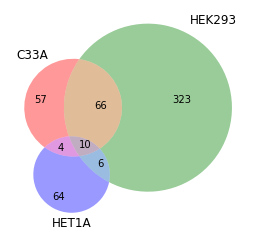

In [66]:
venn3([set(df_C33A['interaction']), set(df_HEK293['interaction']), set(df_HET1A['interaction'])], 
      ('C33A', 'HEK293', 'HET1A'))

plt.savefig("../data/Venn_3cell.pdf",format="pdf")

In [67]:
print len(set(df_HEK293['interaction']))
print len(set(df_HET1A['interaction']))

405
84
